[*********************100%***********************]  1 of 1 completed


C:\Users\AKSHAT\AppData\Local\Temp/ipykernel_3652/592591200.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'] = np.where((data['MA_21'] > data['MA_55']) & (data['MA_21'].shift(1) < data['MA_55'].shift(1)), 1, 0)
C:\Users\AKSHAT\AppData\Local\Temp/ipykernel_3652/592591200.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'] = np.where((data['MA_21'] < data['MA_55']) & (data['MA_21'].shift(1) > data['MA_55'].shift(1)), -1, data['Signal'])
C:\Users\AKSHAT\AppData\Local\Temp/ipy

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-05-11   2020-05-11
End Period                 2023-07-03   2023-07-03
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       70.0%

Cumulative Return          118.86%      102.4%
CAGR﹪                     18.76%       16.74%

Sharpe                     1.7          1.91
Prob. Sharpe Ratio         99.81%       99.94%
Smart Sharpe               1.53         1.72
Sortino                    2.41         2.8
Smart Sortino              2.17         2.53
Sortino/√2                 1.7          1.98
Smart Sortino/√2           1.53         1.79
Omega                      1.47         1.47

Max Drawdown               -18.48%      -12.93%
Longest DD Days            407          609
Volatility (ann.)          15.6%        12.34%
R^2                        0.62         0.62
Information Ratio          -0.02        -0.02
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-10-19,2022-05-06,2023-06-19,609,-12.927282,-12.508555
2,2020-08-31,2020-09-24,2020-11-05,67,-7.222241,-5.030056
3,2021-01-21,2021-01-29,2021-02-02,13,-6.424298,-5.263963
4,2021-03-04,2021-03-25,2021-05-28,86,-6.043965,-5.039563
5,2020-05-14,2020-05-18,2020-05-27,14,-5.500848,-4.988914


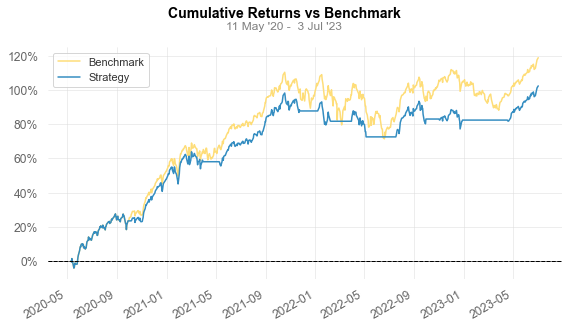

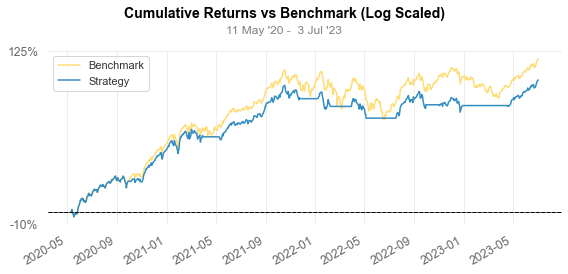

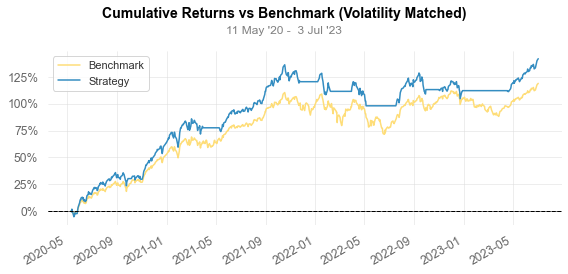

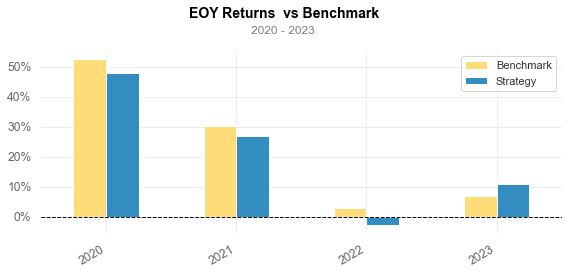

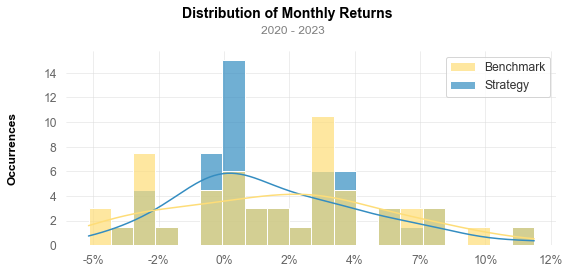

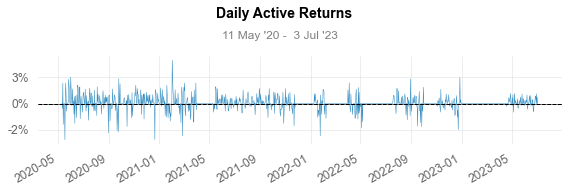

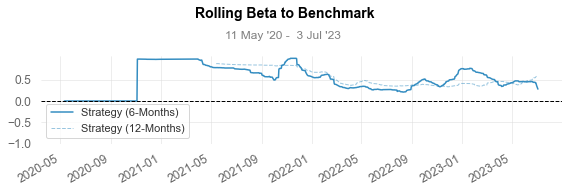

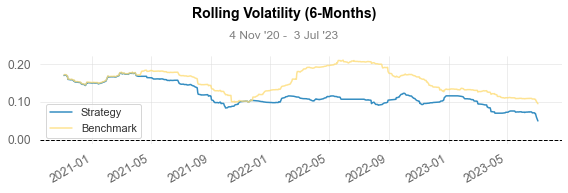

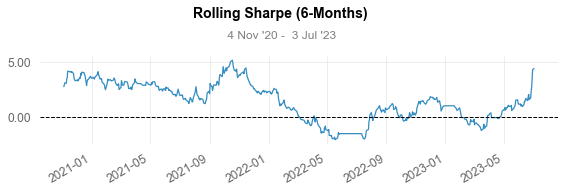

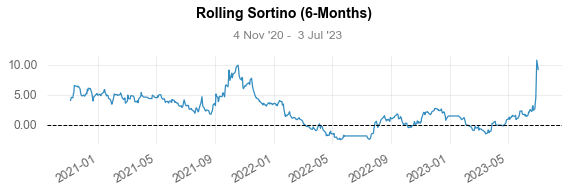

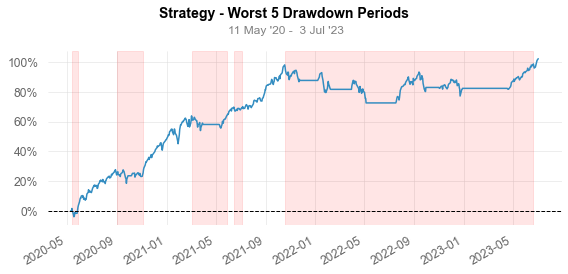

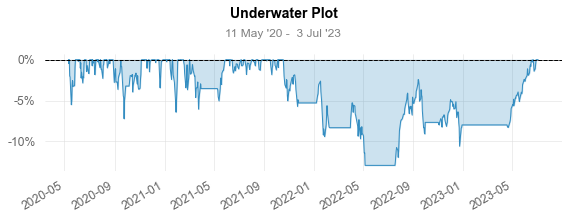

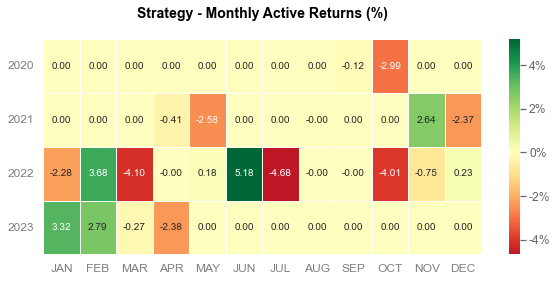

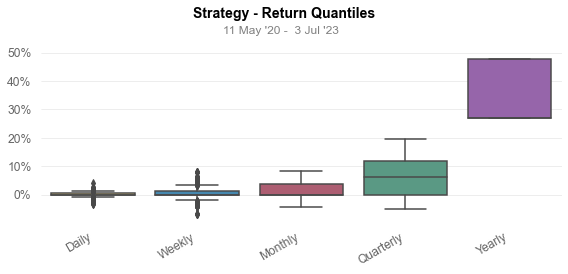

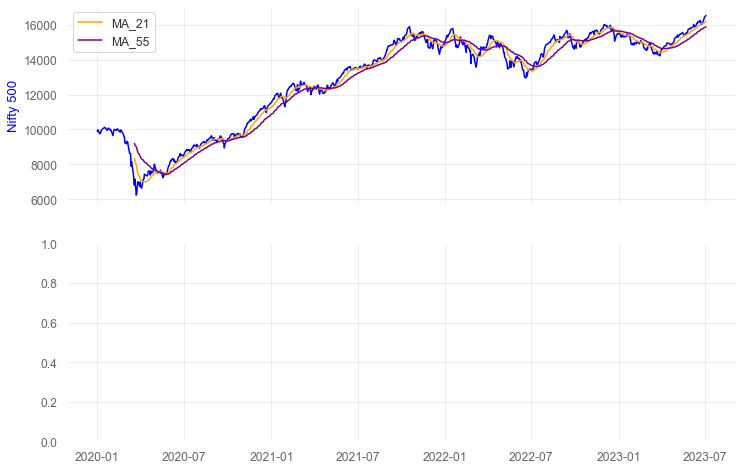

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

def calculate_average_off_ma(symbol):
    # Fetch historical data from yfinance
    data = yf.download(symbol, start='2020-01-01', end='2023-07-04')

    # Calculate 21-day and 55-day Average Off MAs
    data['MA_21'] = np.nan
    data['MA_55'] = np.nan

    # Calculate Average Off MAs
    for i in range(54, len(data)):
        ma_21 = average_off(data['Close'].values[i-20:i+1], 21)
        ma_55 = average_off(data['Close'].values[i-54:i+1], 55)
        data.at[data.index[i], 'MA_21'] = ma_21
        data.at[data.index[i], 'MA_55'] = ma_55

    return data[['Close', 'MA_21', 'MA_55']]

def average_off(data, window):
    """Calculate the average off or average-modified moving average."""
    weights = np.arange(1, window + 1)
    weighted_sum = np.sum(data * weights)
    average_off_ma = weighted_sum / np.sum(weights)
    return average_off_ma

# Example usage for Nifty 500
nifty500 = '^CRSLDX'  # Symbol for Nifty 500 index
data = calculate_average_off_ma(nifty500)

# Determine crossovers
data['Signal'] = np.where((data['MA_21'] > data['MA_55']) & (data['MA_21'].shift(1) < data['MA_55'].shift(1)), 1, 0)
data['Signal'] = np.where((data['MA_21'] < data['MA_55']) & (data['MA_21'].shift(1) > data['MA_55'].shift(1)), -1, data['Signal'])

# Calculate positions and strategy returns
data['Position'] = data['Signal'].cumsum()
data['Strategy_Returns'] = data['Close'].pct_change() * data['Position'].shift(1)

# Create a benchmark (buy and hold Nifty 500 on the first day)
benchmark = pd.DataFrame(index=data.index)
benchmark['Close'] = data['Close']
benchmark['Position'] = 1  # Buy and hold
benchmark['Benchmark_Returns'] = benchmark['Close'].pct_change() * benchmark['Position']

# Backtest the strategy using quantstats
qs.extend_pandas()

# Create a portfolio
portfolio = pd.DataFrame(index=data.index)
portfolio['Close'] = data['Close']
portfolio['Position'] = data['Position']
portfolio['Strategy_Returns'] = data['Strategy_Returns']  # Add the Strategy_Returns column

# Generate the statistics and plots
qs.reports.full(portfolio['Strategy_Returns'], benchmark['Benchmark_Returns'], initial_capital=1000000)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Nifty 500 and Average Off MAs
ax1.plot(data.index, data['Close'], color='blue')
ax1.plot(data.index, data['MA_21'], color='orange', label='MA_21')
ax1.plot(data.index, data['MA_55'], color='purple', label='MA_55')
ax1.set_ylabel('Nifty 500', color='blue')
ax1.legend()


plt.show()
